<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_9_um.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cpu


In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)   # First layer: 784 → 128
        self.fc2 = nn.Linear(128, 64)        # Second layer: 128 → 64
        self.fc3 = nn.Linear(64, 10)         # Output layer: 64 → 10 (digits)

    def forward(self, x):
        x = x.view(-1, 28 * 28)              # Flatten image to 1D vector
        x = F.relu(self.fc1(x))              # Apply ReLU after first layer
        x = F.relu(self.fc2(x))              # ReLU again
        x = self.fc3(x)                      # Final raw scores (logits)
        return x

In [6]:
transform = transforms.Compose(
    [ transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      transforms.Normalize((0.1307), (0.3081))])

trainset = datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.85MB/s]


In [7]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)


for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)
            batch_inputs.to(device)
            batch_labels.to(device)

0 -th batch labels : tensor([8, 1, 1,  ..., 3, 9, 1])
1 -th batch labels : tensor([6, 3, 4,  ..., 6, 9, 9])
2 -th batch labels : tensor([6, 6, 2,  ..., 9, 7, 4])
3 -th batch labels : tensor([7, 5, 3,  ..., 3, 2, 7])
4 -th batch labels : tensor([1, 3, 2,  ..., 6, 6, 2])
0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242

In [8]:

print(device)
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

def train(model, optimizer, epochs):
  model.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
  for epoch in range(epochs):  #  an epoch is a training run through the whole data set

      for batch, data in enumerate(trainloader):
          batch_inputs, batch_labels = data

          batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
          batch_labels = batch_labels.to(device)

          batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

          optimizer.zero_grad()

          batch_outputs = model(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                              #and MLP doesn't apply
                                              #the nonlinear activation after the last layer
          loss = F.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function

          loss.backward()       #this computes gradients as we have seen in previous workshops
          optimizer.step()     #but this line in fact updates our neural network.
      print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
train(model, optimizer, 2)


cpu
epoch: 0 batch: 29 current batch loss: 0.4226934611797333
epoch: 1 batch: 29 current batch loss: 0.2678107023239136


In [18]:
def train_images(model):
  num_steps =300
  lr = 0.05
  target_labels = torch.arange(10, device=device)  # digits 0-9
  dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

  optimizer = torch.optim.Adam([dreamed_images], lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  history = []
  image_snapshots = []

  for step in range(num_steps):
      optimizer.zero_grad()
      output = model(dreamed_images)
      loss = loss_fn(output, target_labels)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
          probs = F.softmax(output, dim=1)
          confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
          history.append(confidence)

      if step % 50 == 0 or step == num_steps - 1:
          print(f"Step {step} | Loss: {loss.item():.4f} | Mean confidence: {np.mean(confidence):.4f}")
          snapshot = dreamed_images.clone().detach().cpu()
          image_snapshots.append(snapshot)

  dreamed_images, confidence_history = dreamed_images.detach(), np.array(history)
  return dreamed_images, confidence_history, image_snapshots
dreamed_images, confidence_history, image_snapshots = train_images(model)

Step 0 | Loss: 2.3932 | Mean confidence: 0.0997
Step 50 | Loss: 0.0007 | Mean confidence: 0.9993
Step 100 | Loss: 0.0004 | Mean confidence: 0.9996
Step 150 | Loss: 0.0003 | Mean confidence: 0.9997
Step 200 | Loss: 0.0002 | Mean confidence: 0.9998
Step 250 | Loss: 0.0002 | Mean confidence: 0.9998
Step 299 | Loss: 0.0002 | Mean confidence: 0.9998


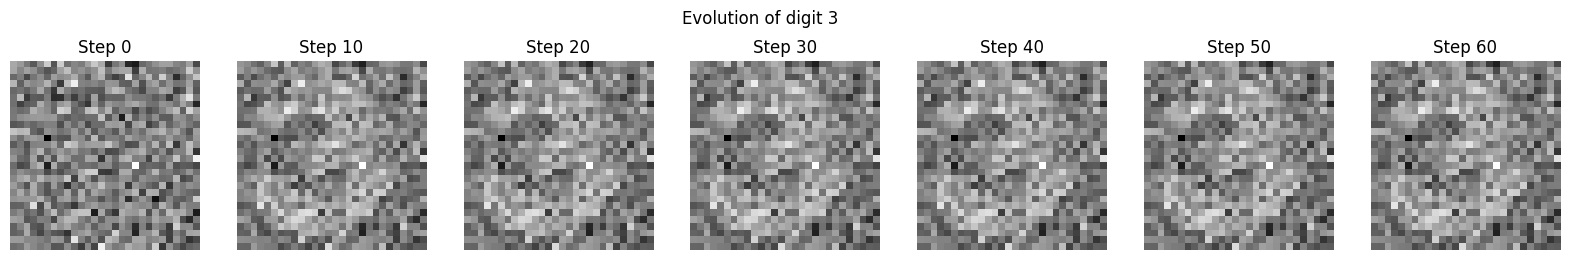

In [19]:
digit_idx = 3  # index from 0 to 9

fig, axes = plt.subplots(1, len(image_snapshots), figsize=(20, 3))
for i, snapshot in enumerate(image_snapshots):
    img = snapshot[digit_idx].squeeze()
    img = (img - img.min()) / (img.max() - img.min())  # normalize
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Step {i*10}")
plt.suptitle(f"Evolution of digit {digit_idx}")
plt.show()

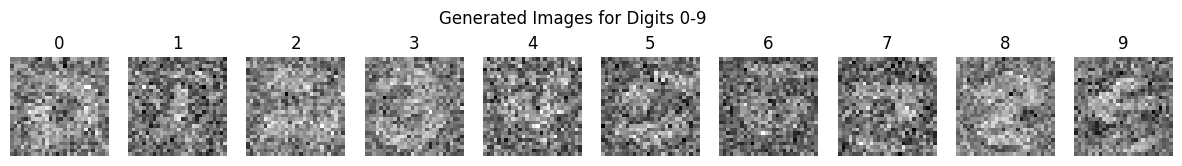

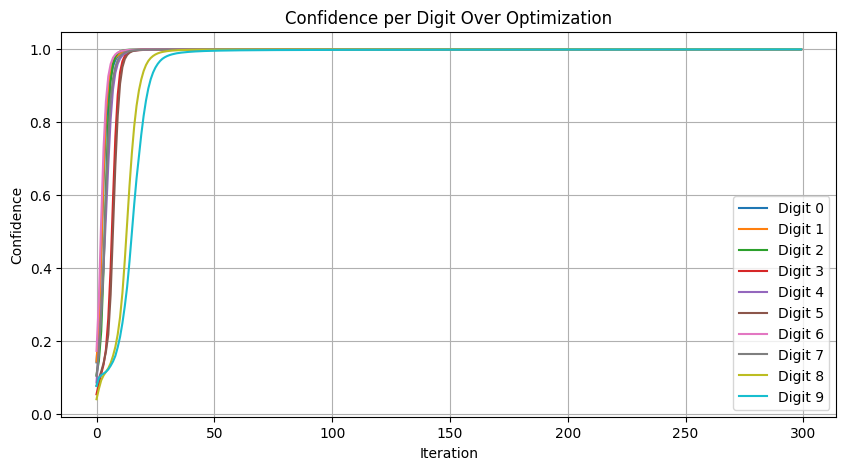

In [20]:
def plot_results(images, confidence_history):
    images = images.cpu().numpy().squeeze()

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(str(i))
    plt.suptitle("Generated Images for Digits 0-9")
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(confidence_history[:, i], label=f"Digit {i}")
    plt.xlabel("Iteration")
    plt.ylabel("Confidence")
    plt.title("Confidence per Digit Over Optimization")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
model.to(device)
model.eval()
plot_results(dreamed_images, confidence_history)

## Pytanie
Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?

Obrazy otrzymane po wytrenowaniu tych z losowymi intensywnościami, tzn. dobraniu ich parametrów (liczb w macierzach tak, aby ustalony model jak najlepiej je klasyfikował) w nieznacznym stopniu przypominają te pisane odręcznie przez ludzi (w szczególności te ze zbioru MNIST). Wynika to ze sposobu działania sieci neuronowej, a w szczególności z metody dobierania wag połączeń między warstwami. Skoro są one dobierane tak aby minimalizować funkcję straty cross-entropy, to często nieoczywiste (dla człowieka) parametry mogą mieć dużą wartość przy przewidywaniu klasy. Może to być np. intensywność wyróżnionego pixela lub obecność na obrazie jakiegoś łuku o podobnej intensywności. Co więcej im więcej jest warstw i więcej epok nauczania tym bardziej szczegółowe analogie sieć wykrywa, gdyż więcej informacji przepływa i ma więcej miejsc do jej zapisania. Jak to się ma do problemu, w którym szukamy optymalnych obrazów dla już wytrenowanego modelu? Otóż optymalizując przewidywanie modelu dla danej klasy (nie realnej klasy) dążymy do tego by macierze opisujące zdjęcia ujawniały wskaźniki klas wykryte przez model, niejako posiadały cechy których model szuka przy klasyfikacji jako dana cyfra. Modele oparte na wielowarstwowych sieciach neuronowych mogą dążyć do zaistnienia szczególnych cech w macierzach (wspominałem wcześniej o ich przykładach) wówczas niejasny dla człowieka rysunek jest wymarzony z perspektywy modelu. Przyjrzyjmy się jak to działa na podstawie eksperymentu. Rozważmy prostą się neuronową (3 wartwy i ReLU między nimi) trenowaną przez 2 epoki. Na podstawie wykresu widzimy, że już po ok.50 krokach obrazy są bardzo dobrze dostosowane do modelu. Natomiast końcowe obrazki mają jedynie rozjaśnione szkice kształtów i tylko trochę przypominają liczby.

# Task 2

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define pairs of digits to simulate
digit_pairs = []
for i in range(6):
    for j in range(i+4, 10):
        digit_pairs.append((i, j))

def dream_dual_digits(model, num_steps=300, lr=0.05):
    dreamed_images = torch.randn((len(digit_pairs), 1, 28, 28), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)  # shape: [5, 10]
        probs = F.softmax(output, dim=1)

        # Create loss to boost confidence in BOTH target digits
        losses = []
        for i, (digit1, digit2) in enumerate(digit_pairs):
            loss1 = -torch.log(probs[i, digit1] + 1e-8)
            loss2 = -torch.log(probs[i, digit2] + 1e-8)
            losses.append((loss1 + loss2) / 2)
        loss = torch.stack(losses).mean()

        loss.backward()
        optimizer.step()

        # Log mean confidence in both targets
        with torch.no_grad():
            confidence = torch.tensor([
                (probs[i, d1] + probs[i, d2])
                for i, (d1, d2) in enumerate(digit_pairs)
            ])
            history.append(confidence.cpu().numpy())

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | Loss: {loss.item():.4f} | Mean confidence: {confidence.mean().item():.4f}")

    return dreamed_images.detach().cpu(), np.array(history)

# Plotting function

def plot_results(images, history, digit_pairs):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i][0], cmap="gray")
        ax.axis("off")
        ax.set_title(f"{digit_pairs[i][0]} & {digit_pairs[i][1]}")
    plt.suptitle("Dreamed Images for Digit Pairs")
    plt.show()

    fig, axes = plt.subplots(1, 11, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i+10][0], cmap="gray")
        ax.axis("off")
        ax.set_title(f"{digit_pairs[i+10][0]} & {digit_pairs[i+10][1]}")

    plt.show()
    # Plot confidence evolution
    history = np.array(history)
    plt.figure(figsize=(20, 10))
    for i, (d1, d2) in enumerate(digit_pairs):
        plt.plot(history[:, i], label=f"{d1}&{d2}")
    plt.title("Confidence in Target Digit Pairs over Time")
    plt.xlabel("Step")
    plt.ylabel("Mean Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()


Step 0 | Loss: 2.4720 | Mean confidence: 0.2005
Step 50 | Loss: 0.6979 | Mean confidence: 0.9961
Step 100 | Loss: 0.6950 | Mean confidence: 0.9981
Step 150 | Loss: 0.6944 | Mean confidence: 0.9987
Step 200 | Loss: 0.6941 | Mean confidence: 0.9990
Step 250 | Loss: 0.6939 | Mean confidence: 0.9992
Step 299 | Loss: 0.6938 | Mean confidence: 0.9994


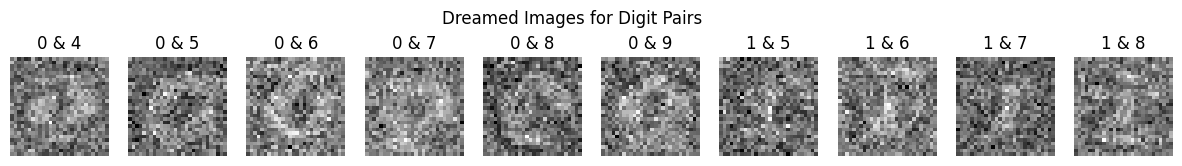

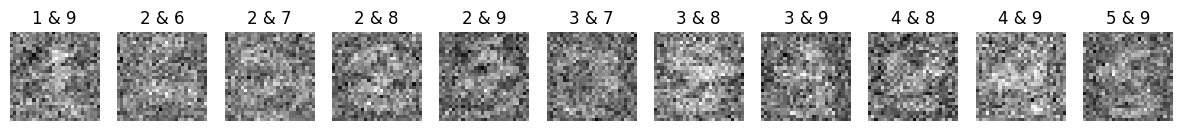

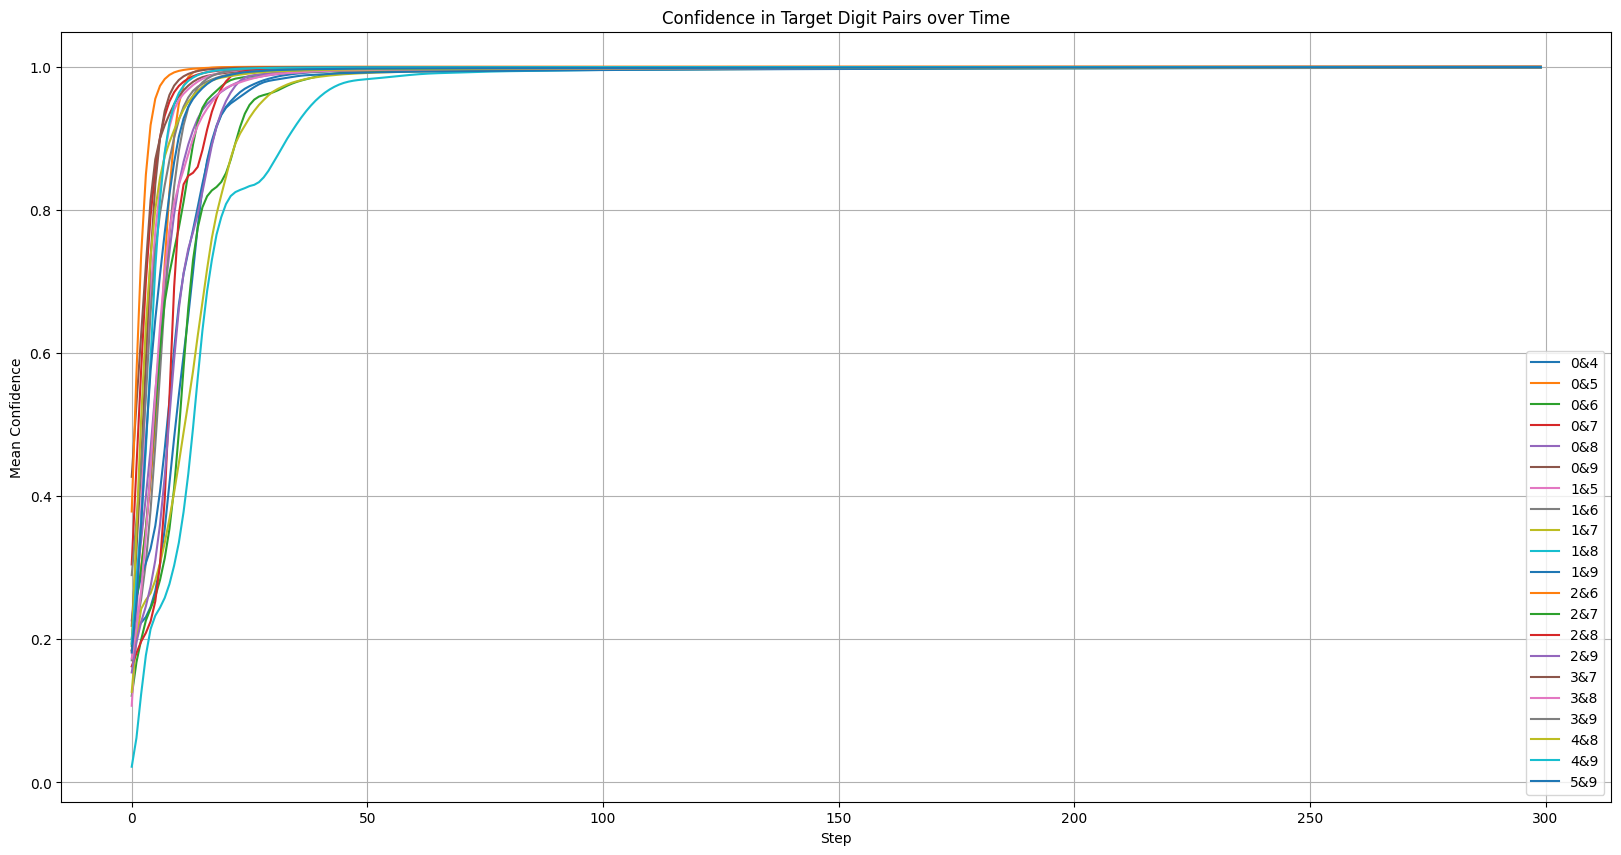

In [22]:
# Call the function using your pretrained model
dreamed_images, history = dream_dual_digits(model)

# Visualize the images and confidence progression
plot_results(dreamed_images, history, digit_pairs)

## Pytanie
Discuss, how you would approach a second task of generating an image that
bares similarity to two or more digits simultaneously.

Problem jest podobny jednak musimy zmodyfikować funkcję straty. Chcemy używać odpowiednika binary cross entropy. Możemy zatem maksymalizować sumę logarytmów prawdopodobieństw oczekiwanych klas (możemy to uśrednić przez liczbę tych klas). Jest to dobre uogólnienie, gdyż w oryginalnej metodzie dla pojedynczej obserwacji maksymalizujemy log(prawdopodobieństwo dobrej klasy), teraz chcemy maksymalizować w równym stopniu p-stwa przynależenia do każdej zadanej dla obrazka klasy (cyfry). Istotnie suma logarytmów to log(iloczynu), a ten przy stałej sumie (idealny przypadek, gdy p-stwo identyfikacji jako jednej z wyróżnionych klas to 1) jest największy gdy te p-stwa są takie same.
Powyżej znajduje się kod który symuluje rozwiązanie dla par klas. Widzimy że nieco wolniej, ale i tak szybko dane wejściowe się dopasowały (wykres pewności) jednak końcowe obrazki ze względu na występowanie cech różnych liczb są zupełnie nieczytelne

# task 3

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
F.softmax  # just so it's clear where it comes from

def dream_digits_l2(model, num_steps=300, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)  # digits 0-9
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 penalty term (squared pixel values)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        # Evaluate confidence
        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

In [29]:
digit_pairs = []
for i in range(6):
    for j in range(i+4, 10):
        digit_pairs.append((i, j))

def dream_dual_digits_l2(model, num_steps=300, lr=0.05, lambda_l2=1):
    dreamed_images = torch.randn((len(digit_pairs), 1, 28, 28), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)  # shape: [5, 10]
        probs = F.softmax(output, dim=1)

        # Create loss to boost confidence in BOTH target digits
        losses = []
        l2_penalty = dreamed_images.pow(2).mean()
        for i, (digit1, digit2) in enumerate(digit_pairs):
            loss1 = -torch.log(probs[i, digit1] + 1e-8)
            loss2 = -torch.log(probs[i, digit2] + 1e-8)
            losses.append((loss1 + loss2) / 2)
        loss = torch.stack(losses).mean()+lambda_l2*l2_penalty

        loss.backward()
        optimizer.step()

        # Log mean confidence in both targets
        with torch.no_grad():
            confidence = torch.tensor([
                (probs[i, d1] + probs[i, d2])
                for i, (d1, d2) in enumerate(digit_pairs)
            ])
            history.append(confidence.cpu().numpy())

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | Loss: {loss.item():.4f} | Mean confidence: {confidence.mean().item():.4f}")

    return dreamed_images.detach().cpu(), np.array(history)


In [24]:
def plot_task3_results(images, history):
    # Plot final generated digits
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()

    # Plot confidence evolution
    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title("Classification Confidence Over Time")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
final_images, confidence_history = dream_digits_l2(model, lambda_l2=1)

Step 0 | CE Loss: 2.7948 | L2: 1.0240 | Mean Conf: 0.0783
Step 50 | CE Loss: 0.0312 | L2: 0.1098 | Mean Conf: 0.9693
Step 100 | CE Loss: 0.0281 | L2: 0.0738 | Mean Conf: 0.9723
Step 150 | CE Loss: 0.0279 | L2: 0.0733 | Mean Conf: 0.9725
Step 200 | CE Loss: 0.0279 | L2: 0.0734 | Mean Conf: 0.9725
Step 250 | CE Loss: 0.0279 | L2: 0.0734 | Mean Conf: 0.9726
Step 299 | CE Loss: 0.0279 | L2: 0.0734 | Mean Conf: 0.9725


Step 0 | CE Loss: 2.2515 | L2: 1.0158 | Mean Conf: 0.1132
Step 50 | CE Loss: 0.0000 | L2: 1.7991 | Mean Conf: 1.0000
Step 100 | CE Loss: 0.0000 | L2: 1.6141 | Mean Conf: 1.0000
Step 150 | CE Loss: 0.0000 | L2: 1.3979 | Mean Conf: 1.0000
Step 200 | CE Loss: 0.0001 | L2: 1.1893 | Mean Conf: 0.9999
Step 250 | CE Loss: 0.0001 | L2: 1.0007 | Mean Conf: 0.9999
Step 299 | CE Loss: 0.0002 | L2: 0.8406 | Mean Conf: 0.9998


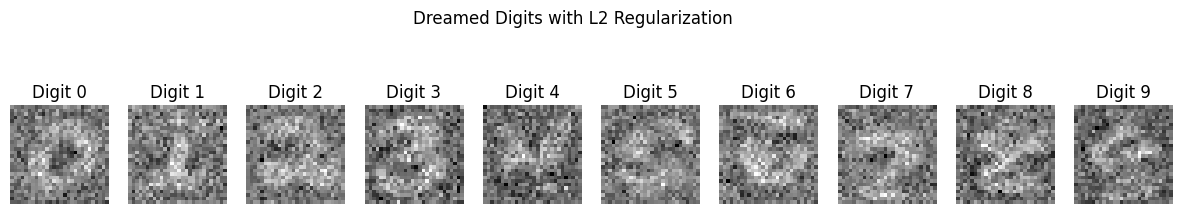

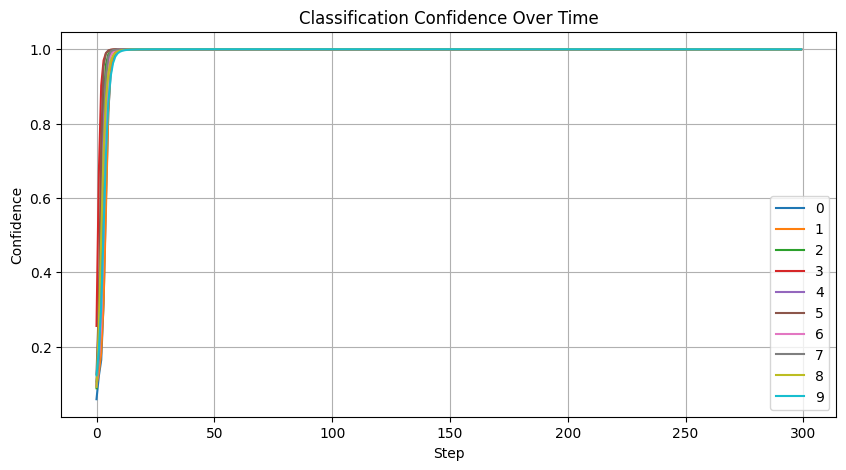

Step 0 | CE Loss: 2.3039 | L2: 0.9729 | Mean Conf: 0.1038
Step 50 | CE Loss: 0.0001 | L2: 1.0796 | Mean Conf: 0.9999
Step 100 | CE Loss: 0.0019 | L2: 0.4340 | Mean Conf: 0.9981
Step 150 | CE Loss: 0.0036 | L2: 0.2248 | Mean Conf: 0.9964
Step 200 | CE Loss: 0.0038 | L2: 0.1677 | Mean Conf: 0.9962
Step 250 | CE Loss: 0.0039 | L2: 0.1492 | Mean Conf: 0.9962
Step 299 | CE Loss: 0.0039 | L2: 0.1427 | Mean Conf: 0.9961


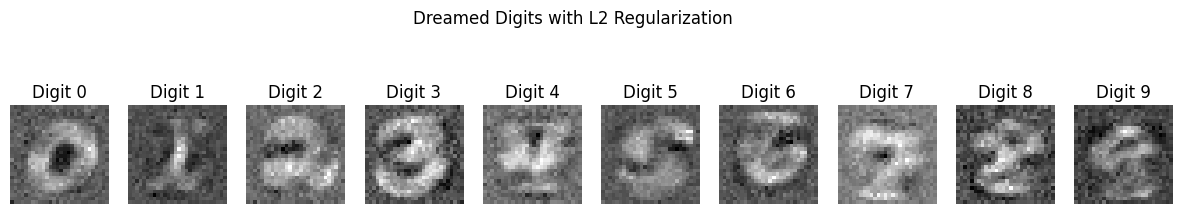

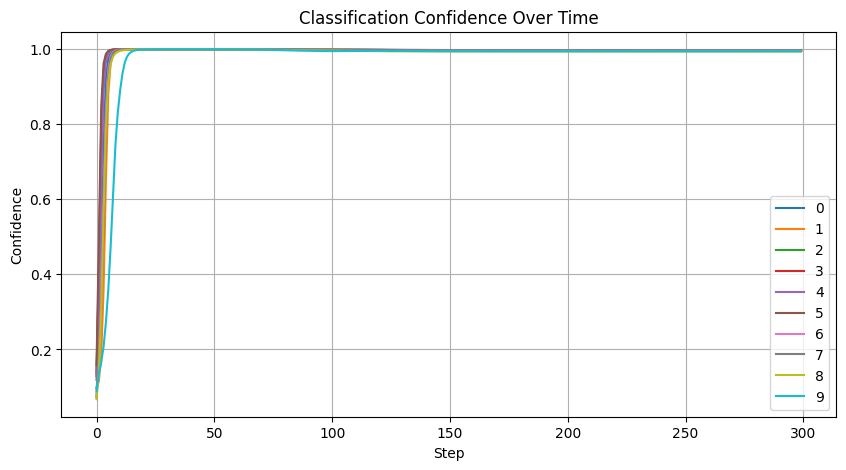

Step 0 | CE Loss: 2.4013 | L2: 0.9934 | Mean Conf: 0.1070
Step 50 | CE Loss: 0.0366 | L2: 0.0914 | Mean Conf: 0.9642
Step 100 | CE Loss: 0.0278 | L2: 0.0738 | Mean Conf: 0.9726
Step 150 | CE Loss: 0.0278 | L2: 0.0734 | Mean Conf: 0.9726
Step 200 | CE Loss: 0.0278 | L2: 0.0734 | Mean Conf: 0.9726
Step 250 | CE Loss: 0.0278 | L2: 0.0734 | Mean Conf: 0.9726
Step 299 | CE Loss: 0.0279 | L2: 0.0734 | Mean Conf: 0.9725


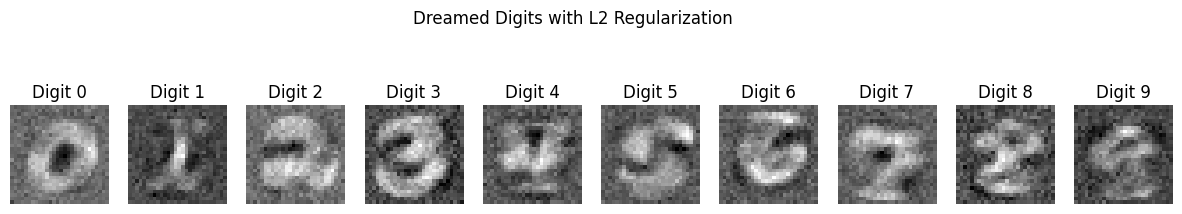

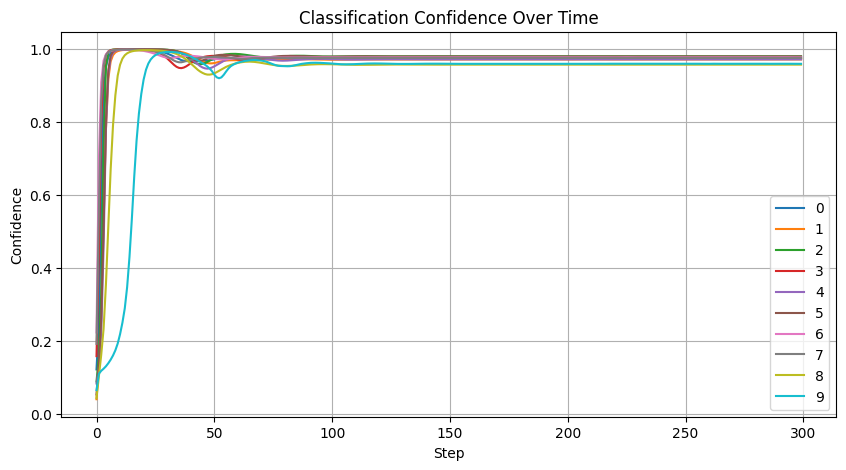

Step 0 | CE Loss: 2.6133 | L2: 1.0229 | Mean Conf: 0.0833
Step 50 | CE Loss: 0.1909 | L2: 0.0322 | Mean Conf: 0.8278
Step 100 | CE Loss: 0.1859 | L2: 0.0296 | Mean Conf: 0.8314
Step 150 | CE Loss: 0.1851 | L2: 0.0296 | Mean Conf: 0.8320
Step 200 | CE Loss: 0.1860 | L2: 0.0296 | Mean Conf: 0.8312
Step 250 | CE Loss: 0.1857 | L2: 0.0297 | Mean Conf: 0.8315
Step 299 | CE Loss: 0.1854 | L2: 0.0297 | Mean Conf: 0.8317


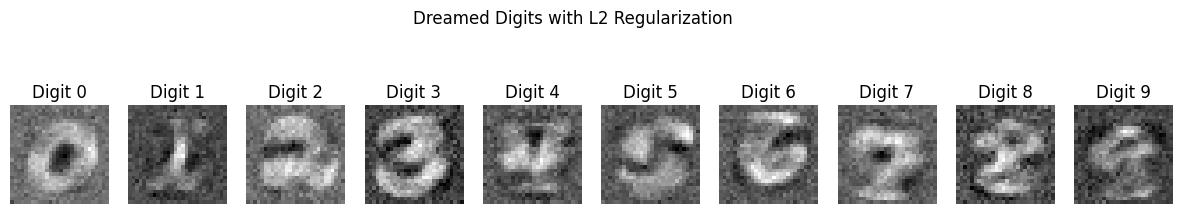

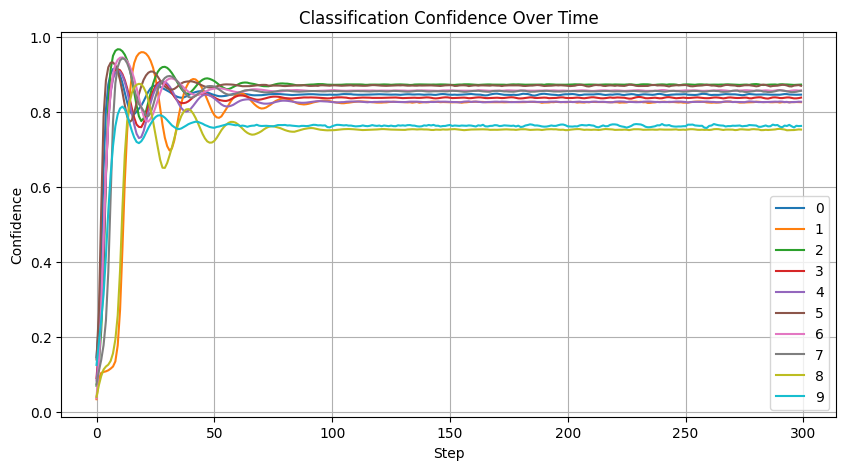

Step 0 | CE Loss: 2.6644 | L2: 1.0293 | Mean Conf: 0.0754
Step 50 | CE Loss: 1.0017 | L2: 0.0074 | Mean Conf: 0.3724
Step 100 | CE Loss: 1.0076 | L2: 0.0049 | Mean Conf: 0.3707
Step 150 | CE Loss: 1.0088 | L2: 0.0049 | Mean Conf: 0.3702
Step 200 | CE Loss: 1.0064 | L2: 0.0049 | Mean Conf: 0.3711
Step 250 | CE Loss: 1.0063 | L2: 0.0049 | Mean Conf: 0.3711
Step 299 | CE Loss: 1.0093 | L2: 0.0049 | Mean Conf: 0.3702


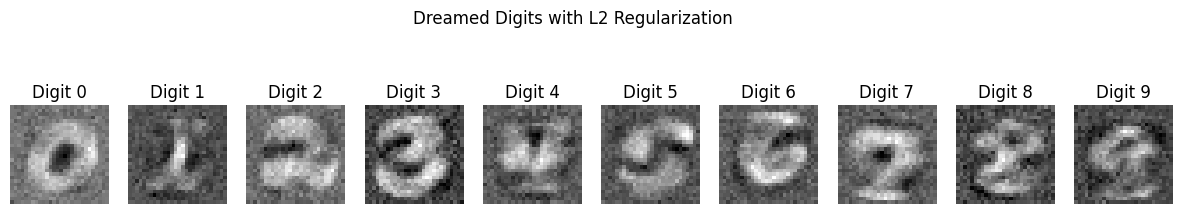

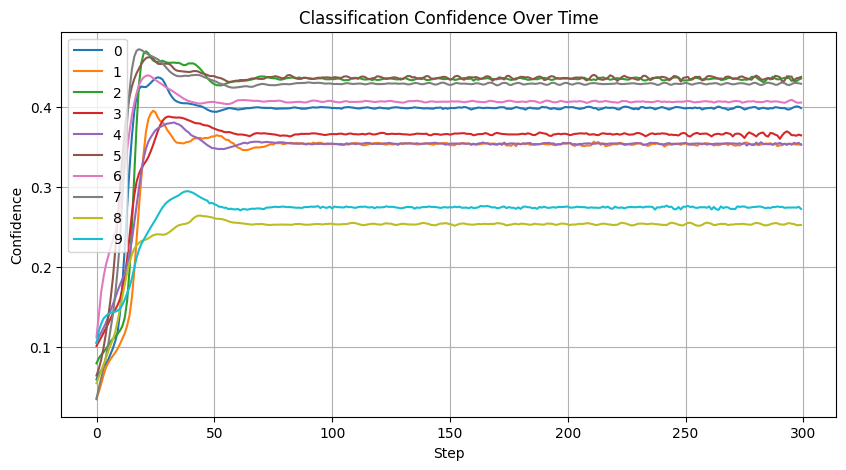

In [26]:
for lam in [0.01, 0.1, 1, 10, 100]:
  final_images, confidence_history = dream_digits_l2(model, lambda_l2=lam)

  # Visualize
  plot_task3_results(final_images, confidence_history)

Step 0 | Loss: 3.4809 | Mean confidence: 0.1877
Step 50 | Loss: 0.9721 | Mean confidence: 0.9512
Step 100 | Loss: 0.8494 | Mean confidence: 0.9506
Step 150 | Loss: 0.8419 | Mean confidence: 0.9509
Step 200 | Loss: 0.8414 | Mean confidence: 0.9510
Step 250 | Loss: 0.8413 | Mean confidence: 0.9511
Step 299 | Loss: 0.8413 | Mean confidence: 0.9511


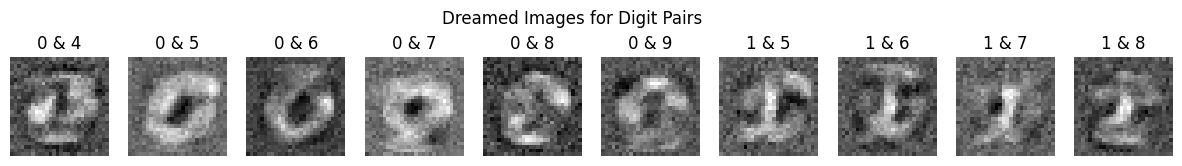

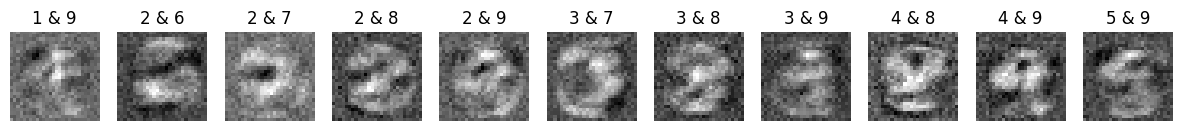

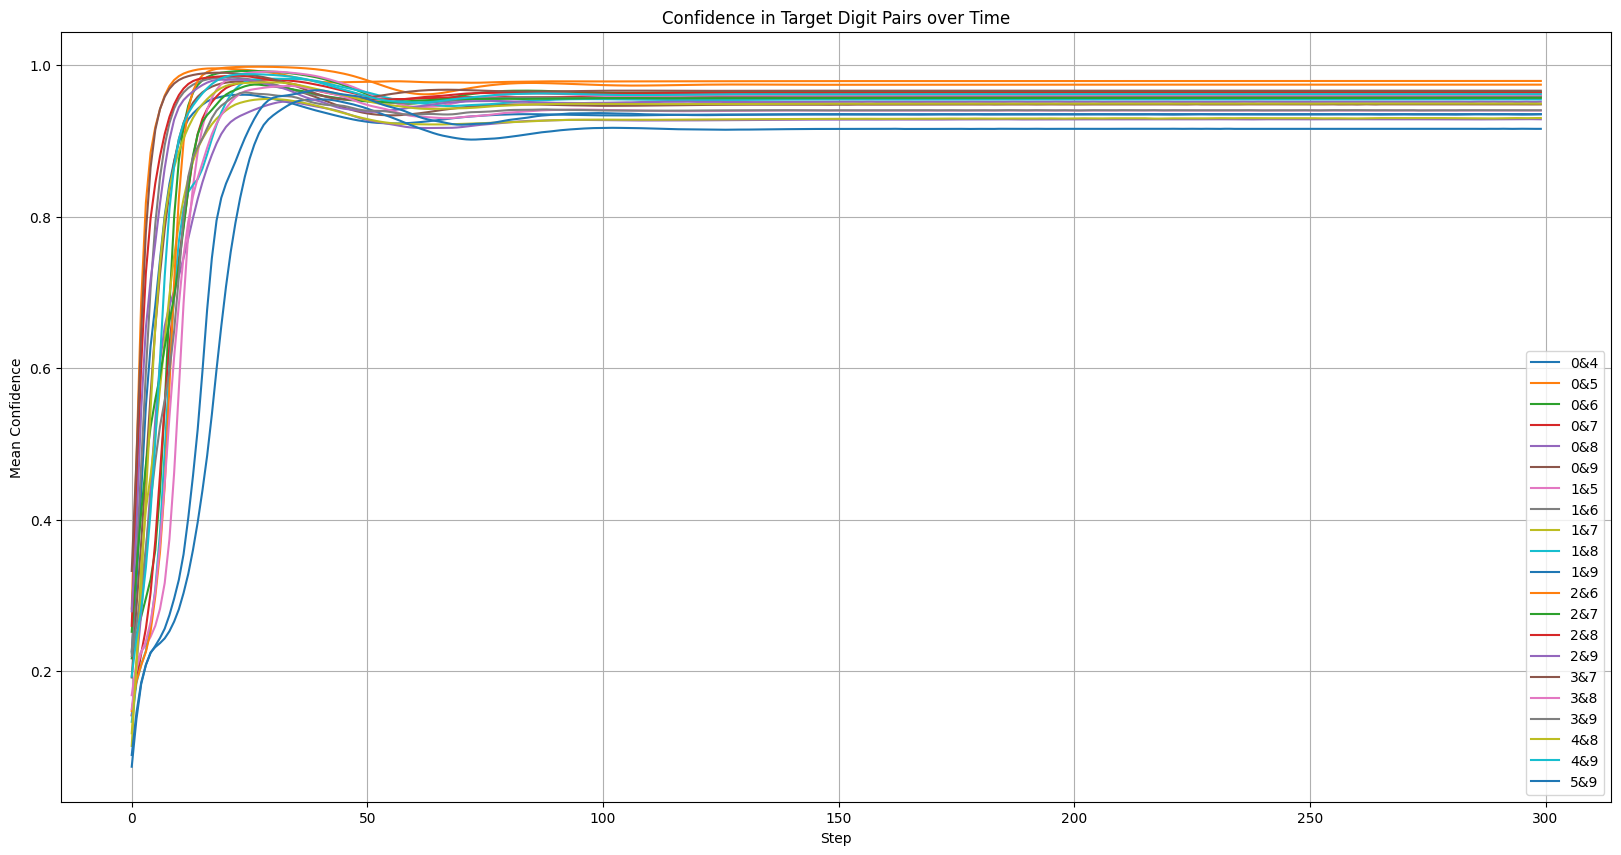

In [30]:
# Call the function using your pretrained model
dreamed_images, history = dream_dual_digits_l2(model)

# Visualize the images and confidence progression
plot_results(dreamed_images, history, digit_pairs)

## Pytanie
Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

Dla niewielkich wartości parametru $\lambda$ pewność predykcji zbiegła jeszcze szybciej do jedynki. Przy wyższych wartościach tego parametru zbiegała ona wolniej bądź nie zbiegała a jedynie oscylowała poniżej 1. Wysokie wartości tego parametru miały jednak zaletę: poprawiały wygląd obrazków, tak że były one czytelniejsze dla człowieka (oprócz tych dla par liczb gdzie równoczesność różnych kształtów tworzyła nietypowe obrazy - por zdjęcia wyżej). Stało się tak ponieważ kara